## SETUP

##### Libraries & API Setup

In [1]:
# Common libraries
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import json 
import pandas as pd
import datetime
from utils import returns_df, plot_sector_performance

In [2]:
# API setup
from messari.messari import Messari                   # Messari
#m = Messari('cb0d3a33-c4c5-4b50-9fff-5dce65d44b97')   # Messari
m = Messari('f8783744-faf2-475e-8675-b3769cd55c81')   # Messari
from pycoingecko import CoinGeckoAPI                  # Coingecko
cg = CoinGeckoAPI()                                   # Coingecko
API_KEY = '27mKdxqslM3aORzuco6LoqzKjFc'               # Glassnode

##### Import Data

In [3]:
start = '2022-01-01'
end = '2022-03-31'
sector = ('UNI', 'CRV', 'LRC', 'SUSHI')

In [4]:
cdata = pd.DataFrame(cg.get_coins_markets('usd'))

In [5]:
mdata = m.get_all_assets(asset_fields=['metrics'], to_dataframe=True)
prices = m.get_metric_timeseries(list(sector), 'price', start, end)
asset_returns = returns_df(prices)

In [6]:
ldata = pd.DataFrame(requests.get('https://api.llama.fi/protocols').json())

##### Coarse Merge

In [7]:
cdata['symbol'].str.lower()
master = cdata.merge(ldata, how = 'left', left_on = 'symbol', right_on = 'symbol')

In [8]:
master = master.merge(mdata, how = 'left', left_on = 'id_x', right_on = 'slug')

In [9]:
master.head()

,id_x,symbol,name_x,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,metrics_supply_distribution_supply_in_contracts_usd,metrics_supply_distribution_supply_in_contracts_native_units,metrics_supply_distribution_supply_shielded,metrics_supply_distribution_supply_in_top_100_addresses,metrics_supply_distribution_supply_in_top_10_percent_addresses,metrics_supply_distribution_supply_in_top_1_percent_addresses,metrics_supply_distribution_supply_in_utxo_in_loss,metrics_supply_distribution_supply_in_utxo_in_profit,metrics_alert_messages,slug_y
0,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,40901.000000,778409052966,1,8.596410e+11,3.091314e+10,41119.000,...,NaN,NaN,None,2.932434e+06,1.882346e+07,1.740021e+07,6.670937e+06,1.234360e+07,None,bitcoin
1,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,3063.490000,369499744569,2,NaN,1.837984e+10,3086.340,...,9.424190e+10,3.145038e+07,None,4.715580e+07,1.177552e+08,1.150306e+08,NaN,NaN,None,ethereum
2,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1.000000,82802308838,3,NaN,6.276536e+10,1.004,...,NaN,NaN,None,1.149024e+09,1.326209e+09,1.291699e+09,NaN,NaN,None,tether
3,binancecoin,bnb,BNB,https://assets.coingecko.com/coins/images/825/...,417.830000,70301663190,4,7.030166e+10,1.603253e+09,419.930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,usd-coin,usdc,USD Coin,https://assets.coingecko.com/coins/images/6319...,0.998903,49876973310,5,NaN,4.940602e+09,1.006,...,1.896819e+10,1.897266e+10,None,2.706734e+10,4.406573e+10,4.228059e+10,NaN,NaN,None,usd-coin


## METRICS

### Price Action 

In [10]:
idx = pd.IndexSlice
sector_prices = prices.loc[:, idx[sector, 'close']].droplevel(1, axis = 1)

<AxesSubplot:xlabel='timestamp'>

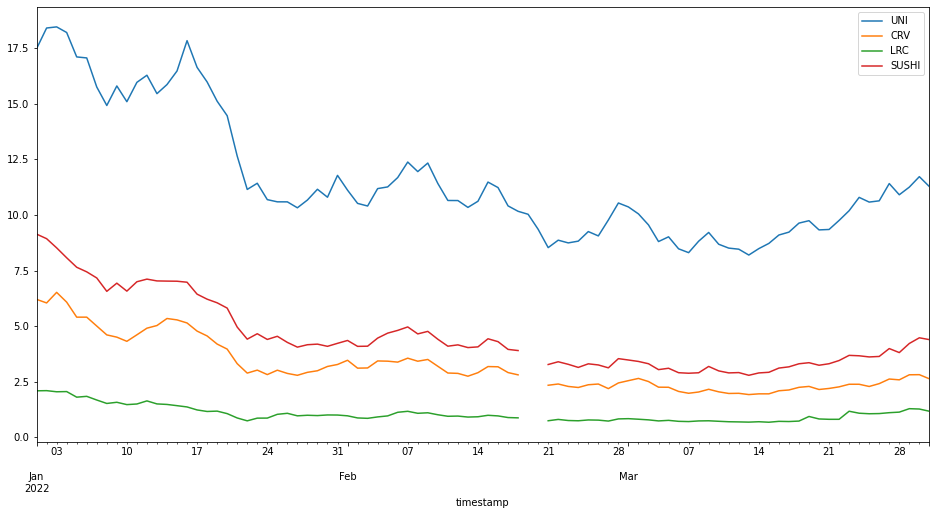

In [11]:
sector_prices.plot(figsize=(16, 8))

### Returns

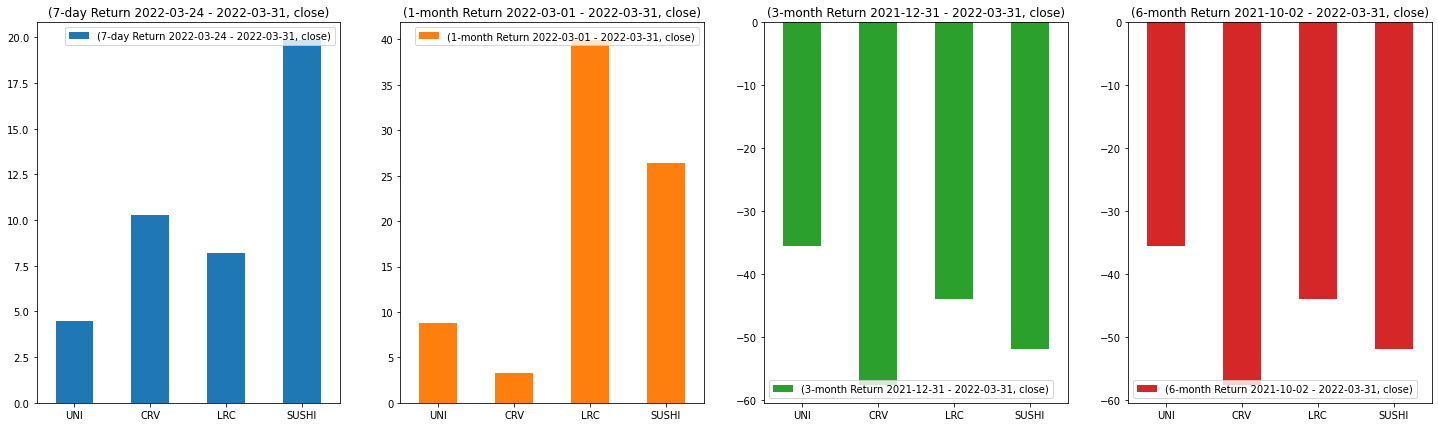

In [12]:
idx = pd.IndexSlice
sector_returns = asset_returns.loc[idx[sector, 'close'], :]
ax = sector_returns.unstack(level=1).plot(kind='bar', subplots=True, rot=0, figsize=(25, 7), layout=(1, 4))

### TVL

In [13]:
ldata = ldata.set_index('symbol')
sector_names = ldata.loc[list(sector), 'name']

historic_tvl = pd.DataFrame()

for name in sector_names.values:
    # Get TVL data
    url = 'https://api.llama.fi/protocol/' + name.lower()
    historic_tvl = historic_tvl.append(requests.get(url).json(), ignore_index = True)

historic_tvl_df = pd.DataFrame(historic_tvl)

name_chain_tvl = pd.DataFrame()
for row in range(4):
    # Get name
    name = historic_tvl_df.loc[row, 'name']
    
    # Get chain data as dataframe
    chain_tvls = historic_tvl_df.loc[row, 'chainTvls']
    
    # Iterate over chains
    for key in historic_tvl_df.loc[0, 'chainTvls']:
        # Make column name
        col_name = name + "_" + key
        
        # Get TVL values as DF
        tvl_df = pd.DataFrame(historic_tvl_df.loc[0, 'chainTvls'][key]['tvl'])
        
        # Change name of column
        tvl_df.rename(columns = {'totalLiquidityUSD': col_name}, inplace = True)
        
        # Add tvl data under this name to name_chain_tvl
        if name_chain_tvl.empty:
            name_chain_tvl = tvl_df
        else:
            name_chain_tvl = name_chain_tvl.merge(tvl_df, how = 'left', left_on = 'date', right_on = 'date')

# Fix date format and set as index
name_chain_tvl['date'] = pd.to_datetime(name_chain_tvl['date'], unit = 's')
name_chain_tvl = name_chain_tvl.set_index('date')

<AxesSubplot:xlabel='date'>

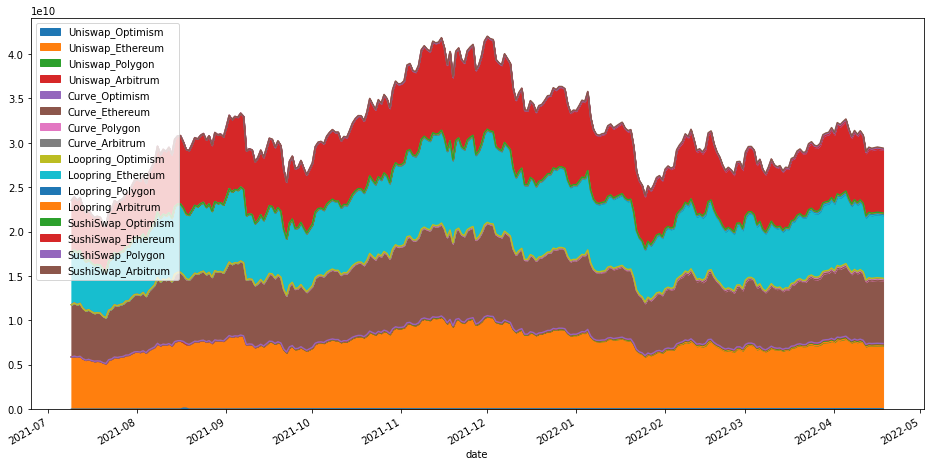

In [18]:
name_chain_tvl.plot.area(figsize = (16, 8))

### On-chain Metrics